This pipeline opens the result of fsl's melodic analysis, lets the user interactively label the components that look like neuronal activity (rather than movement artefacts or noise), sort them by label, plots a final summary for the chosen components, and save the reordered maps and time series.

In [1]:
clear all

In [2]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy import io
import scipy.io as sio
%matplotlib inline 
import pylab
import csv
from Tkinter import Tk
from tkFileDialog import askopenfilename
from tkFileDialog import askdirectory
import nibabel as nb

In [3]:
Tk().withdraw() # we don't want a full GUI, so keep the root window from appearing
foldername = askdirectory() # show an "Open" dialog box and return the path to the selected file
print(foldername)

/media/ICA/964ss1_250.ica/filtered_func_data.ica


Open time series

In [4]:
f = open(foldername+"/melodic_mix",'r')

In [1]:
lines = list(f)

NameError: name 'f' is not defined

In [6]:
myarray = np.asarray(lines)

In [7]:
for i in range(len(myarray)):
    if i==0:
        DTa=np.fromstring(myarray[i],dtype='float32',sep=' ')
    else:
        A=np.fromstring(myarray[i],dtype='float32',sep=' ')
        DTa=np.vstack((DTa,A))

In [8]:
DTa.shape

(6127, 250)

If have used only melodic

In [9]:
DT=DTa

If have used matlab to do a distributed svd first



In [13]:
Tk().withdraw() # we don't want a full GUI, so keep the root window from appearing
filename = askopenfilename() # show an "Open" dialog box and return the path to the selected file
print(filename)
Ua=sio.loadmat(filename)

()


IOError: Reader needs file name or open file-like object

In [11]:
u=Ua['u']
DT=np.dot(u,DTa)
DT.shape

Open maps

In [10]:
img1 = nb.load(foldername+'/melodic_IC.nii.gz')
data = img1.get_data()
S=data.shape
S

(101, 88, 11, 250)

#Open time

In [13]:
Tk().withdraw() # we don't want a full GUI, so keep the root window from appearing
filename = askopenfilename() # show an "Open" dialog box and return the path to the selected file
print(filename)

/home/sophie/Desktop/Data964_.csv


In [15]:
with open(filename) as inputfile:
    results = list(csv.reader(inputfile))

In [59]:
Raw_timea=[float(results[i][2]) for i in (range(1,len(results)))]

In [62]:
Raw_time=np.asarray(Raw_timea[0:len(results)])

In [65]:
Raw_time.shape

(6292,)

First and last frames in which excitation is full on

In [70]:
on=126
off=6253
Time_fluo=Raw_time[on:off]-Raw_time[on]

In [71]:
Time_fluo.shape

(6127,)

# Stimulus time series

In [101]:
Tmax=np.max(Time_fluo)
Tstim=np.array(range(1,100*(int(Tmax)+1)))
Tstim=Tstim/100
Odor=np.zeros(len(Tstim*100))
UV=np.zeros(len(Tstim*100))

In [104]:
for i in range(0,7):
    UV[10*100+i*600:100*10+i*600+300]=1
    
for i in range(0,5):    
    Odor[(10+8*6+15)*100+i*600:(10+8*6+15)*100+i*600+200]=1

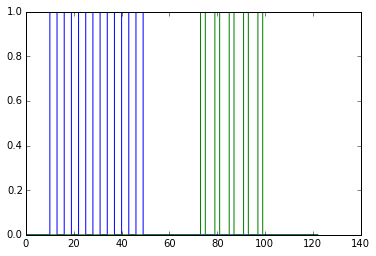

In [105]:
plt.plot(Tstim,UV)
plt.plot(Tstim,Odor)

# Behavior

* Cut the behavior movies to keep only frames with excitation on
* Analyze the behavior by hand (using Video_annotate) or measuring the ball movement with PIV (in FIJI)
* Extract time embedded in the movies, using avi2time

In [106]:
Tk().withdraw() # we don't want a full GUI, so keep the root window from appearing
filename = askopenfilename() # show an "Open" dialog box and return the path to the selected file
print(filename)
B=sio.loadmat(filename)

/media/LaCie/964vid/matlab.mat


In [109]:
Tb=B['T']
Left=B['green']
Right=B['blue']

In [122]:
%store

Stored variables and their in-db values:


# Zscore maps

In [110]:
Demean=np.zeros(S)
Dmaps=np.zeros(S)
Dvar=np.zeros(S)
Var=np.zeros(S[3])
D2=np.zeros([S[0],S[1],5,S[3]])
Tvar=np.zeros(S[3])

Transform the maps to have zero mean

In [111]:
for i in range(S[3]):
    Demean[:,:,:,i]=data[:,:,:,i]-np.mean(np.mean(np.mean(data[:,:,:,i],0),0),0)

Transform the maps to have unit variance and zscore

In [112]:
for i in range(S[3]):
    Dsq=np.reshape(Demean[:,:,:,i],S[0]*S[1]*S[2])
    Var[i]=np.sqrt(np.var(Dsq))
    Dvar=Demean[:,:,:,i]/Var[i]
    Dmaps[:,:,:,i]=Dvar-2
    Tvar[i]=np.var(DT[i,:])
Dmaps[Dmaps<0]=0

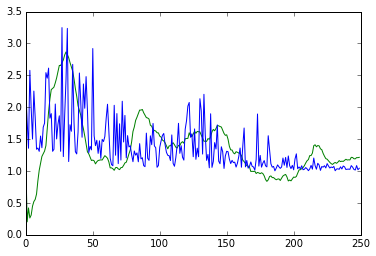

In [113]:
plt.plot(Tvar,'g')
plt.plot(Var)

Order ICs by variance before normalization if ICA done in matlab

In [114]:
Order=np.argsort(Var)[::-1]
datao=data[:,:,:,Order[:]]
Dmapso=Dmaps[:,:,:,Order[:]]
Varor=Var[Order]

# Compute time series using the zscored maps as ROI
Open original data

In [115]:
from nifti import NiftiImage

In [56]:
Tk().withdraw() # we don't want a full GUI, so keep the root window from appearing
filenameo = askopenfilename() # show an "Open" dialog box and return the path to the selected file
print(filenameo)
nim=NiftiImage(filenameo)
global Do
Do=nim.data

/media/Buffer3/964/964ss1cregcU7sMpsfkf.nii


In [57]:
So=Do.shape
So

(6127, 11, 88, 101)

The following code is very slow. Need to parallelize here or in matlab with parfor. 

In [58]:
TS_ROI=np.zeros([S[3],So[0]])
for j in range(S[3]):
    for k in range(So[0]):
        TS_ROI[j][k]=sum(sum(sum(sum([Do[k][:][:][:]*Dmaps[:,:,:,j].T]))))
    A=TS_ROI[j][:]
    V=np.sqrt(np.var(A))
    TS_ROI[j][:]=A/V

#Separate maps in substacks, sort the independent components by brain regions 

In [116]:
my_cmap=plt.cm.jet
my_cmap.set_bad(alpha=0)
Good_ICs=np.zeros(S[3])
Label_ICs=[]
pylab.rcParams['figure.figsize'] = (13, 2.5)

In [117]:
Tk().withdraw() 
filenamet = askopenfilename() 
print(filenamet)
nimt=NiftiImage(filenamet)
Dtemp=np.squeeze(nimt.data.T)
Dtemp.shape

()


ValueError: Unsupported source type. Only NumPy arrays and filename string are supported.

In [118]:
Dtemp=np.mean(data,3)

In [119]:
Dtemp.shape

(101, 88, 11)

In [120]:
%%javascript
IPython.OutputArea.auto_scroll_threshold =4000;

In [121]:
if S[2]>5:
    Nstack=5
    Int100=[(i+1)*100/Nstack for i in range(Nstack)]
    Percs=np.percentile(range(S[2]),Int100)
    Indices=np.split(range(S[2]),Percs)
    D1=np.zeros([S[0],S[1],Nstack])
    #Dmean=np.squeeze(data[:,:,range(Nstack),2])
    for i in range(Nstack):
        Vmean=np.mean(Dtemp[:,:,Indices[i]],2)
        Dmean[:,:,i]=Vmean
else:
    Nstack=S[2]
    D1=np.zeros([S[0],S[1],S[2]])
    Dmean=data[:,:,range(S[2])]  
    Dmean=np.squeeze(Dtemp[:,:,:])

NameError: name 'Dmean' is not defined

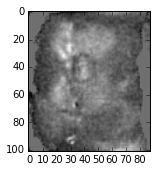

In [82]:
plt.imshow(Dmean[:,:,1],cmap=plt.cm.gray)

In [69]:
Dmean.shape

(101, 88, 5)

In [70]:
Nstack

5

0


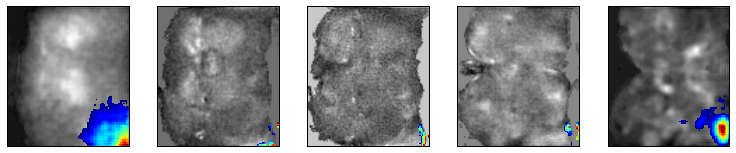

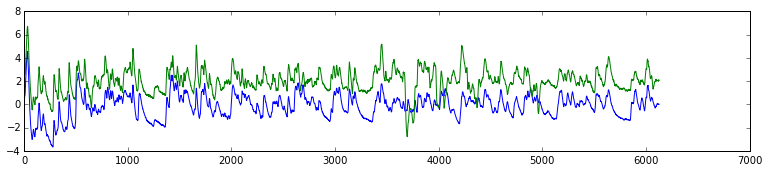

SOG
1


/usr/local/lib/python2.7/dist-packages/numpy/ma/core.py:4085: UserWarning: Warning: converting a masked element to nan.
  warnings.warn("Warning: converting a masked element to nan.")


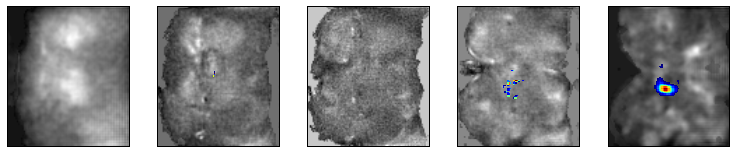

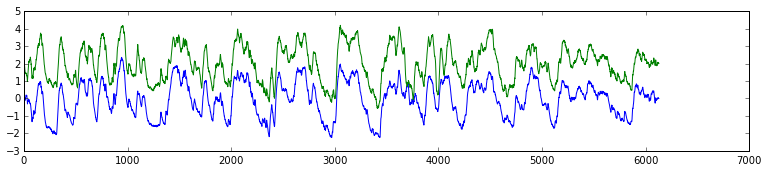

PB
2


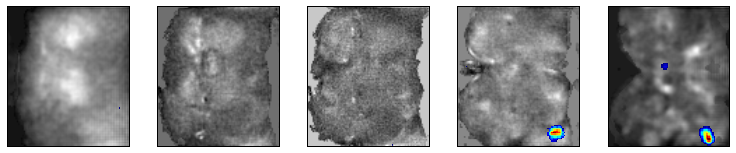

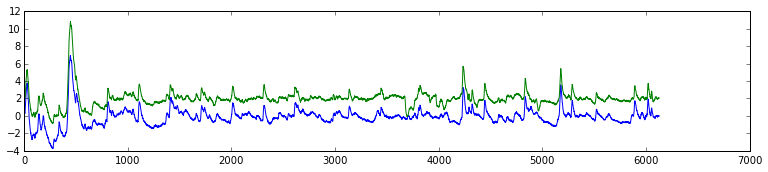

PCB
3


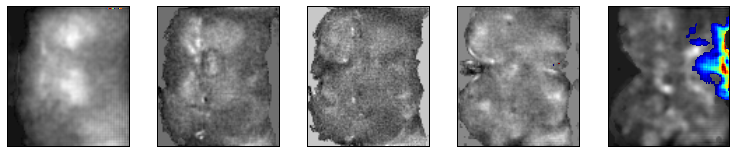

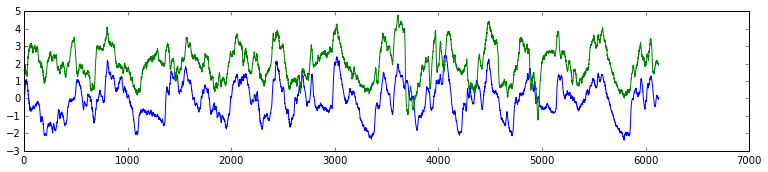


4


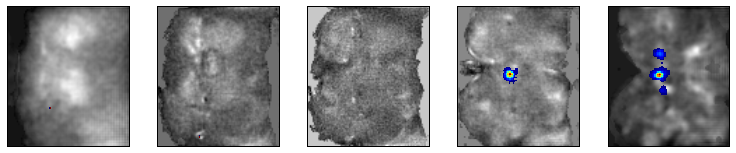

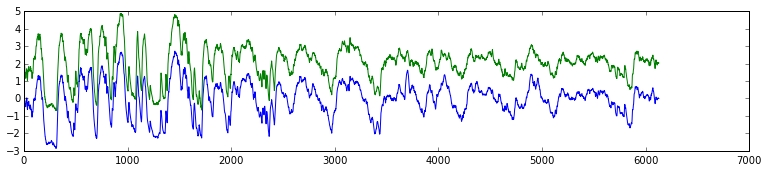

PB
5


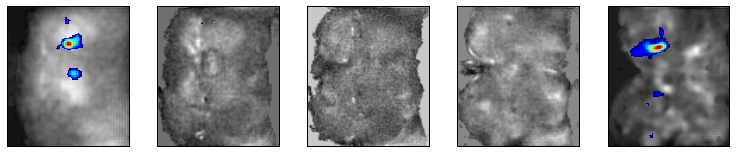

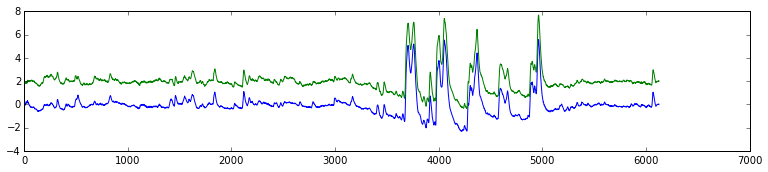

PN
6


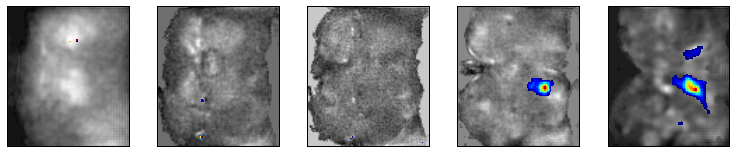

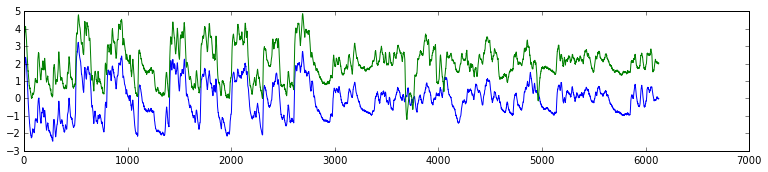

PS
7


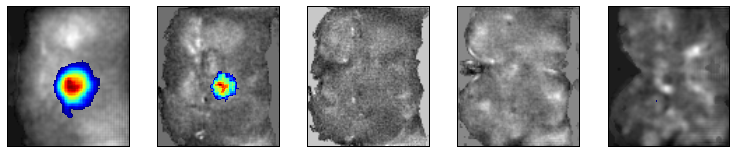

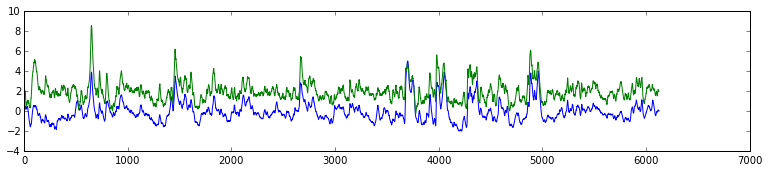

AL
8


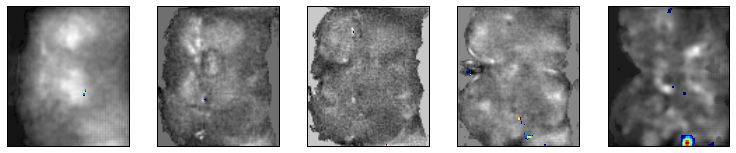

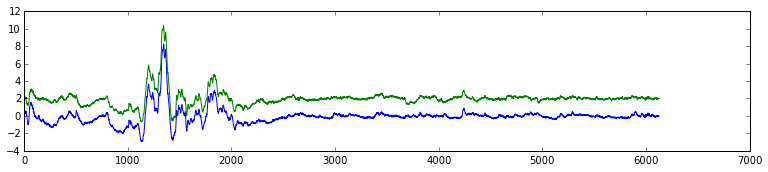

DCB
9


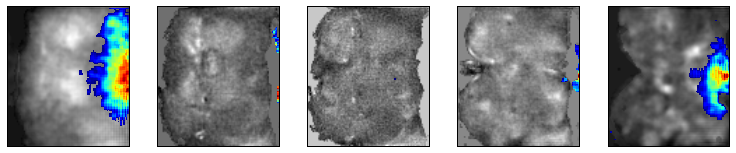

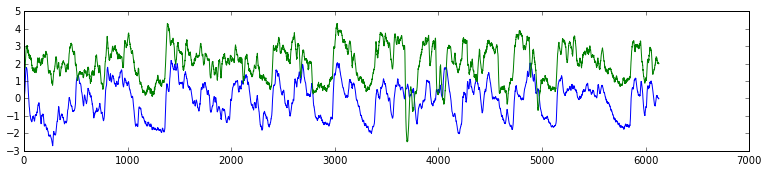


10


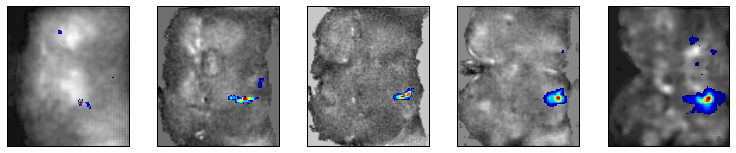

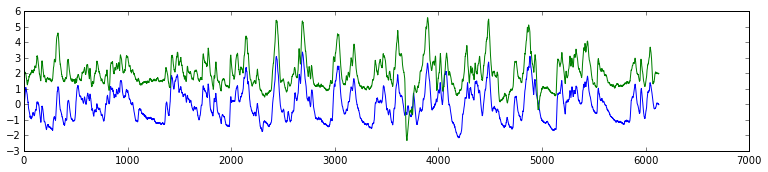

PS
11


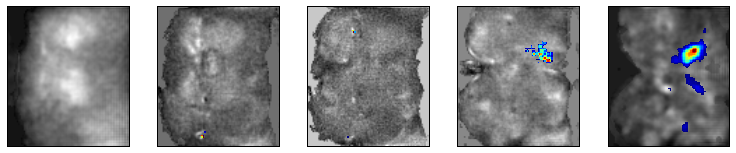

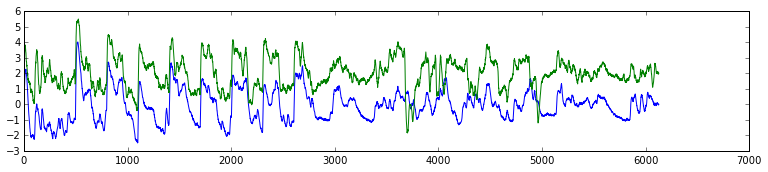

PS
12


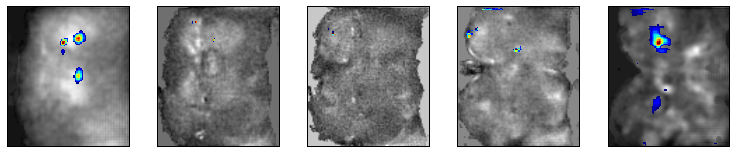

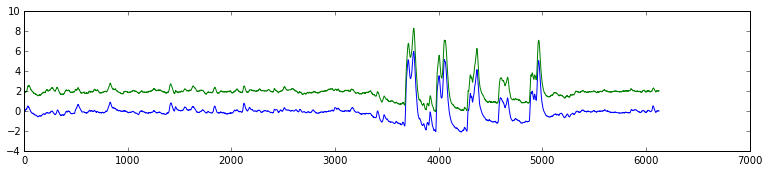

PN
13


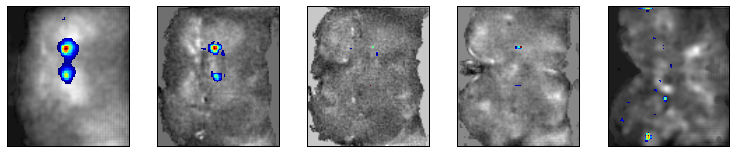

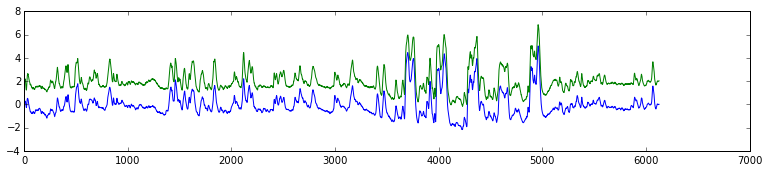

AL
14


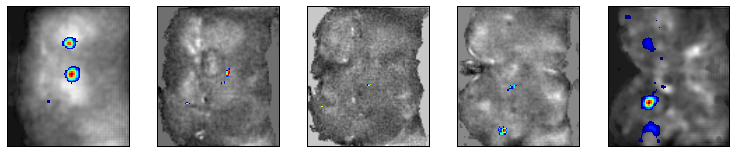

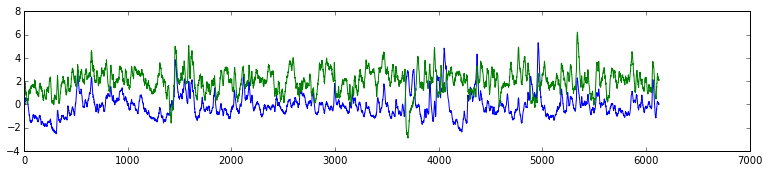

PN
15


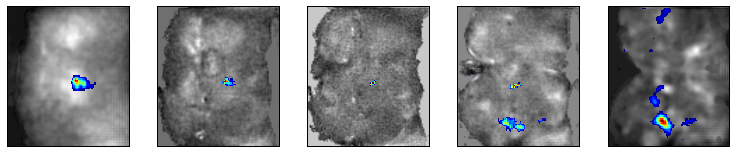

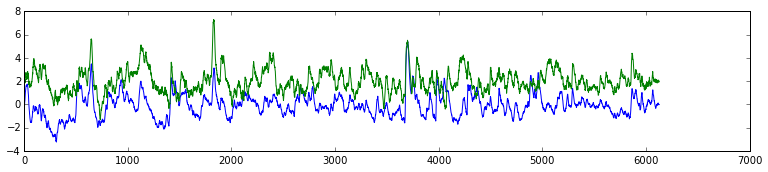

PN
16


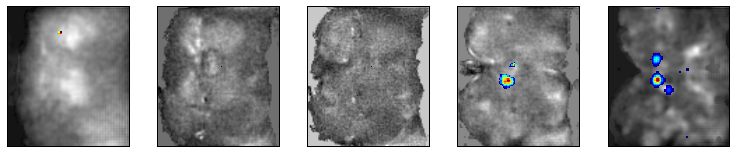

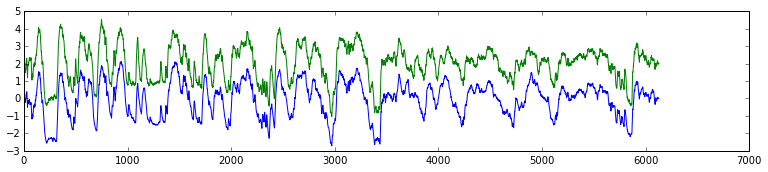

PB
17


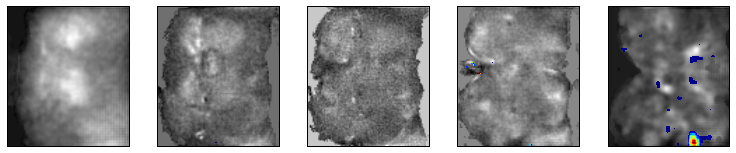

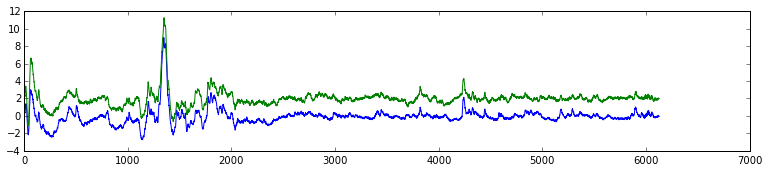

DCB
18


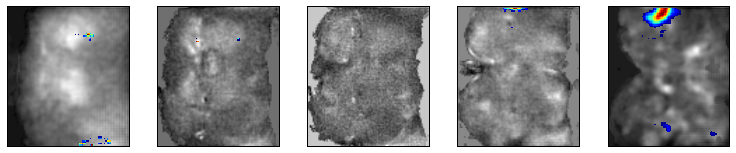

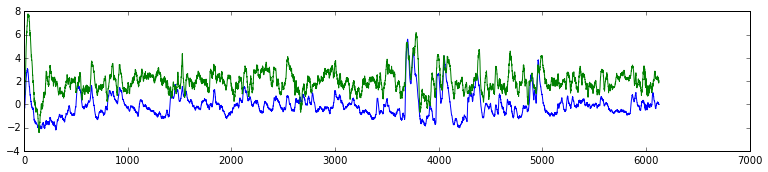

PN
19


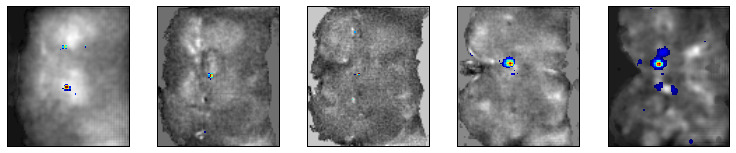

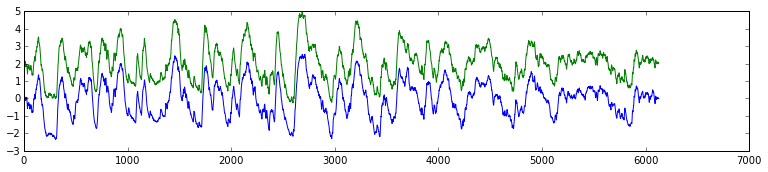

PB
20


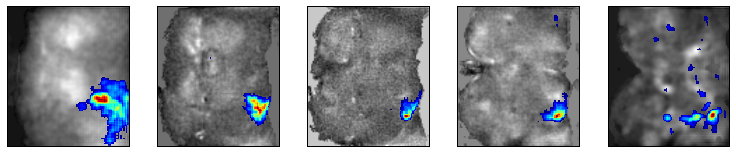

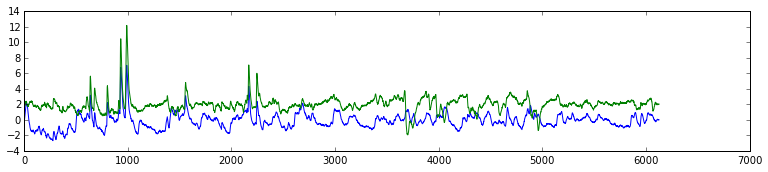

SOG
21


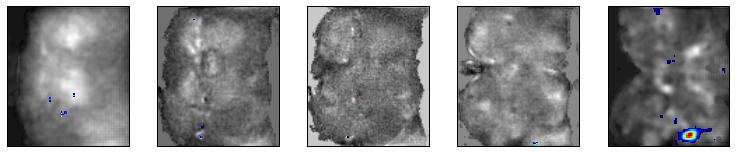

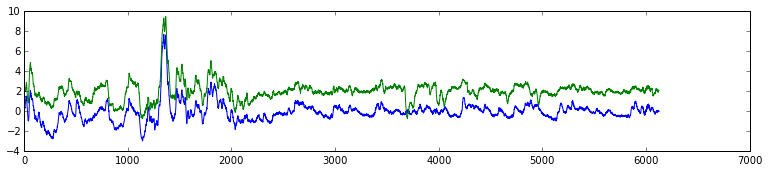

DCB
22


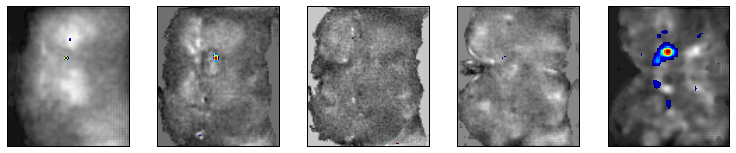

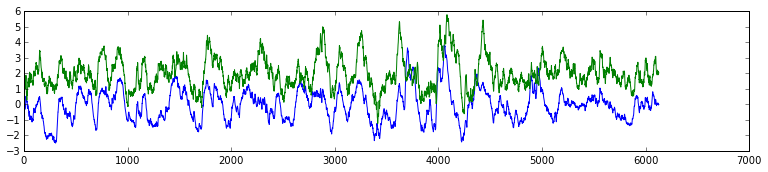

PB
23


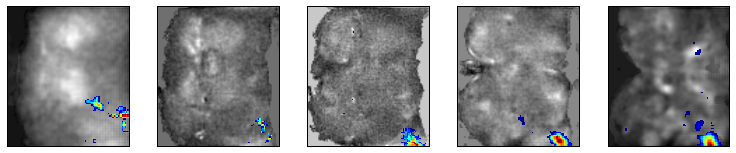

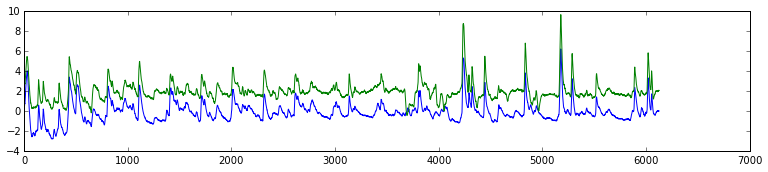

SOG
24


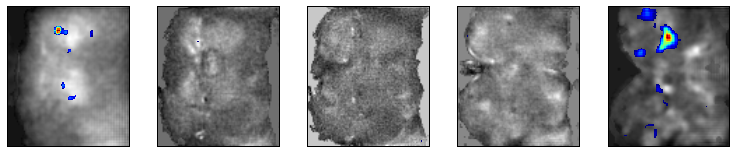

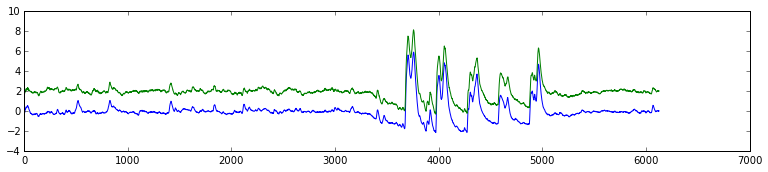

PN
25


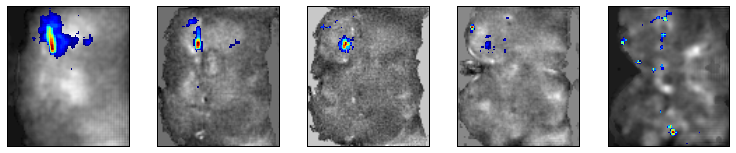

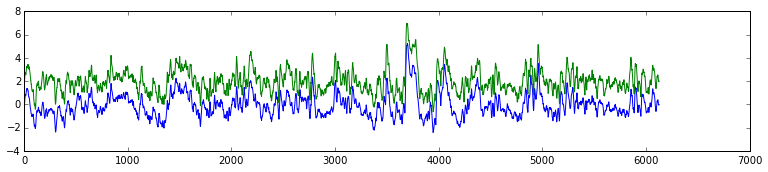

MB
26


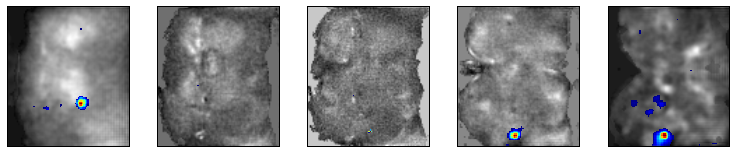

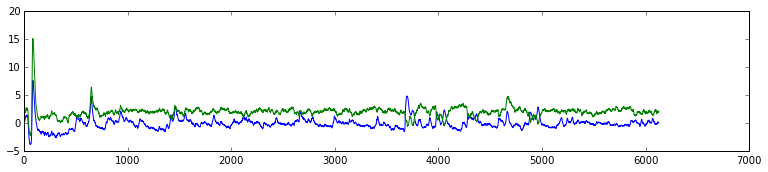

PN
27


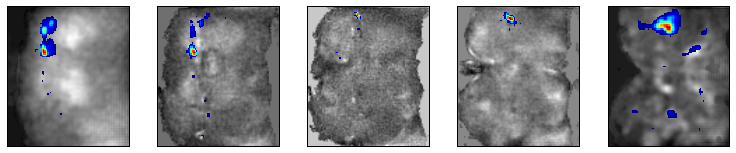

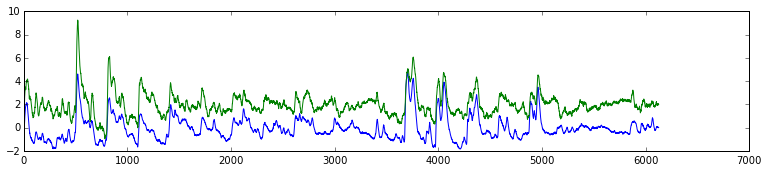

MB
28


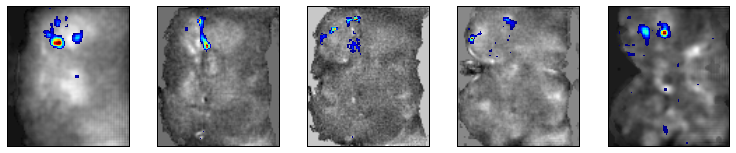

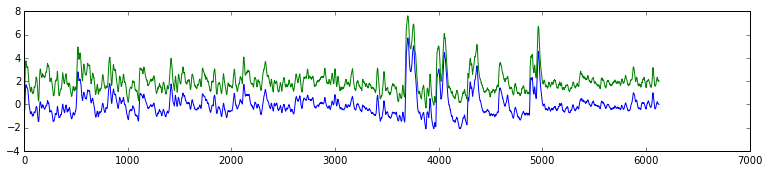

KC
29


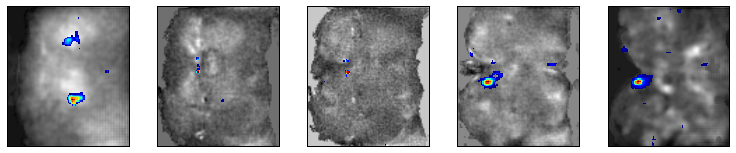

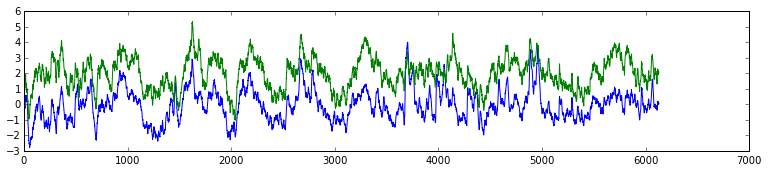

AL
30


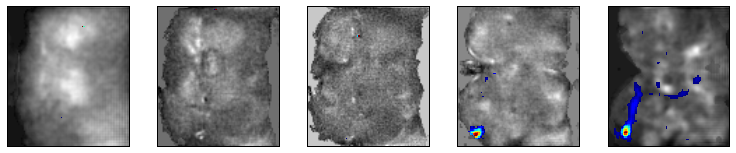

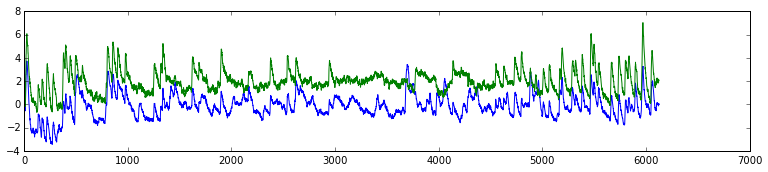

DCB
31


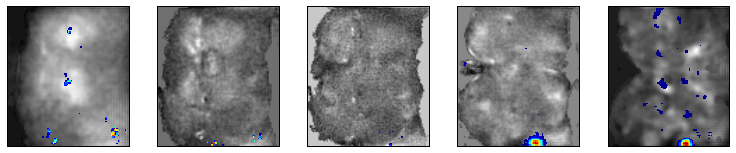

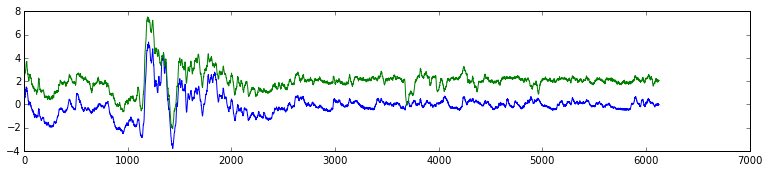

DCB
32


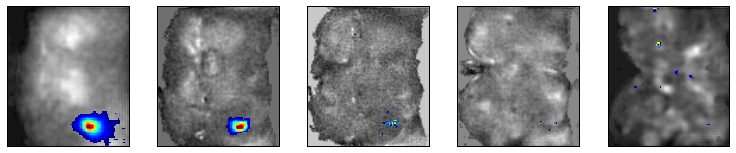

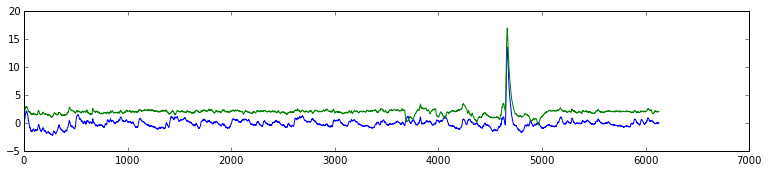

In [ ]:
for j in range(S[3]):

    if S[2]>5:
        for i in range(Nstack):
            V=Dmaps[:,:,Indices[i],Order[j]]
            D1[:,:,i]=np.max(V,2)
        D2[:,:,:,j]=D1
        D1[D1==0]=np.nan
           
    else:
        for i in range(S[2]):
            V=Dmaps[:,:,i,Order[j]]
            D1[:,:,i]=V 
            

    print(j)
    for i in range(Nstack):
        plt.subplot(1,5,i+1)
        plt.imshow(Dmean[:,:,i],cmap=plt.cm.gray)
        plt.imshow(D1[:,:,i], cmap=my_cmap,interpolation='none')
        frame1 = plt.gca()
        frame1.axes.get_xaxis().set_visible(False)
        frame1.axes.get_yaxis().set_visible(False)
        
    plt.show()
    
    plt.plot(TS_ROI[Order[j],:])
    plt.plot(DT[:,Order[j]]+2)
    plt.show()
    
    Label_ICs.append(raw_input())
    if Label_ICs[j]=='':
        Good_ICs[j]=0
    else:
        Good_ICs[j]=1
        
        

In [38]:
Dmaps.shape

(92, 57, 9, 200)

In [68]:
Label_ICs

['O',
 'O',
 'SOG',
 'O',
 'O',
 'KC',
 'KC',
 'MB',
 'AL',
 '',
 '',
 'o',
 'KC',
 'o',
 'eb',
 'ammc',
 'mb',
 'o',
 'SOG',
 'SOG',
 'AL',
 'o',
 'MB',
 'SOG',
 'o',
 'o',
 'o',
 'D',
 '',
 'MB',
 'AVLP',
 'SOG',
 'FB',
 'PB',
 '',
 '',
 '',
 'MB',
 'EB',
 '',
 'LH',
 'MB',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 'MB',
 'PB',
 '',
 '',
 'D',
 '',
 '',
 '',
 '',
 '',
 'KC',
 '',
 '',
 '',
 '',
 '',
 'o',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 'MB',
 '',
 '',
 '',
 'MB',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 'MB',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',

In [69]:
set(Label_ICs)

{'',
 'AL',
 'AVLP',
 'D',
 'EB',
 'FB',
 'KC',
 'LH',
 'MB',
 'O',
 'PB',
 'SOG',
 'ammc',
 'eb',
 'mb',
 'o'}

In [70]:
if len(Label_ICs)<S[3]:
    for j in range(S[3]-len(Label_ICs)):
      Label_ICs.append('')  

In [71]:
Dict={'a':0,'AL':0,'Co':1,'CO':1,'O':2,'o':2,'OG':3,'AVLP':3,'A':0,'G':5,'PN':5,'CA':6,'L':4,'LH':6,'l':6,'KC':7,'kc':7,'M':7,'MB':1,'mb':1,'FB':2,'EB':3,'eb':8,'C':4,'c':8,'PB':9,'pb':9,'AMMC':10,'ammc':10,'V':5,'S':11,'SOG':11,'s':11,'I':12,'i':12,'D':5,'':14,'0':14}

In [72]:
Translated=[Dict[X] for X in Label_ICs]

In [73]:
G=Good_ICs.tolist();

In [74]:
len(Good_ICs)

200

In [75]:
G.count(1)

43

In [76]:
where_are_NaNs = np.isnan(D2)

D2[where_are_NaNs] = 0

In [77]:
if S[2]>5:
    Final_map=np.zeros([S[0],S[1],5,3])
    Fmaps=np.zeros([S[0],S[1],5,3])
else:
    Final_map=np.zeros([S[0],S[1],3])
    Fmaps=np.zeros([S[0],S[1],3])    
C=np.zeros([S[3],3])

In [78]:
D2.shape

(92, 57, 9, 200)

In [79]:
for j in range(S[3]):    
    if Good_ICs[j]:
        C[j,:]=np.squeeze(np.random.rand(3,1))
        for k in range(3):
            M=np.max(np.squeeze(np.reshape(D2[:,:,j],S[0]*S[1])))
            #M[M==0]=1
  #          Fmaps[:,:,:,k]=0.7*Dmaps[:,:,:,j]*C[j,k]/np.max(np.squeeze(np.reshape(Dmaps[:,:,:,j]*np.max(C[j,:],S[0]*S[1]*5))
            Fmaps[:,:,:,k]=0.7*D2[:,:,j]*C[j,k]/(M*np.max(C[j,:]))
        Final_map=Final_map+Fmaps

ValueError: total size of new array must be unchanged

TypeError: Invalid dimensions for image data

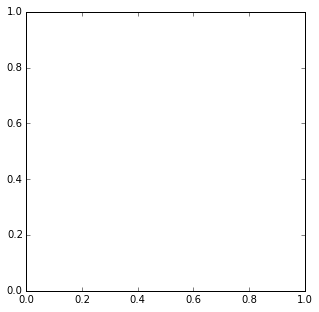

In [64]:
pylab.rcParams['figure.figsize'] = (18, 5)

plt.imshow(Final_map) 
frame1 = plt.gca()
frame1.axes.get_xaxis().set_visible(False)
frame1.axes.get_yaxis().set_visible(False)

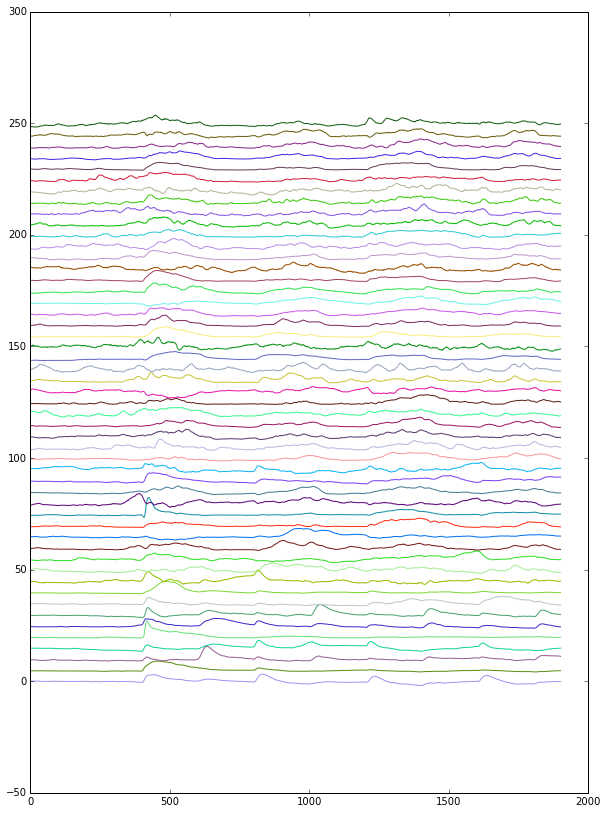

In [67]:
pylab.rcParams['figure.figsize'] = (10, 14)
h=5
i=0

for j in range(S[3]):
    if Good_ICs[j]:
        plt.plot((DT[:,Order[j]]+h*i),color=C[j,:])
        i=i+1

plt.show()

In [449]:
List1=[(Translated[i],i) for i in range(S[3])]

In [450]:
Newlist=sorted(List1, key=lambda List1: List1[0])

In [451]:
Neworder=[Newlist[i][1] for i in range(S[3])  if Newlist[i][0] != 14]

In [452]:
Neworder

[0,
 3,
 5,
 31,
 9,
 14,
 16,
 23,
 25,
 29,
 30,
 68,
 15,
 19,
 72,
 73,
 12,
 27,
 28,
 56,
 71,
 2,
 6,
 10,
 20]

In [453]:
Order[Neworder]

array([ 1,  5,  4, 30,  9, 20, 15, 25, 24, 33, 23, 27,  7, 10, 36, 35, 21,
       17, 12, 32, 31, 13, 16, 14,  8])

In [454]:
[Label_ICs[Neworder[i]] for i in range(len(Neworder))]  

['a',
 'a',
 'a',
 'A',
 'MB',
 'MB',
 'MB',
 'MB',
 'MB',
 'MB',
 'MB',
 'MB',
 'FB',
 'FB',
 'FB',
 'FB',
 'EB',
 'L',
 'L',
 'C',
 'C',
 'D',
 'V',
 'V',
 'V']

In [455]:
NewDT=DT[:,Order[Neworder[:]]].T

In [456]:
NewDT.shape

(25, 1506)

In [457]:
for j in range(len(Neworder)):
    A=NewDT[:,j]
    V=np.sqrt(np.var(A))
    NewDT[:,j]=A/V

In [458]:
C1=np.zeros([6,3])
C1[0][:]=(1,0,0)
C1[1][:]=(0,1,0)
C1[2][:]=(0,0,1)
C1[3][:]=(0.8,0.8,0)
C1[4][:]=(0,1,1)
C1[5][:]=(1,0,1)

In [459]:
S1=DT.shape
S1

(1506, 75)

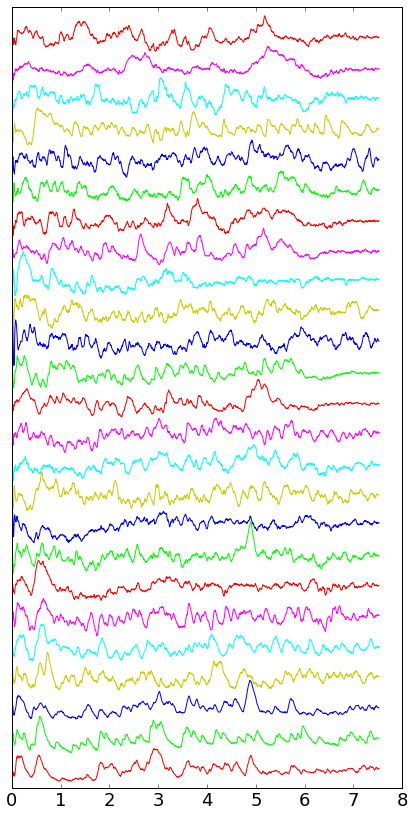

In [487]:
h=5
pylab.rcParams['figure.figsize'] = (7, 14)
i=0
t=[j*0.005 for j in range(S1[0])]

for j in range(len(Neworder)):
        plt.plot(t,NewDT[j,:]+h*j,color=C1[i%6][:])
        i=i+1
plt.ylim([-3,h*j+5])

frame1=plt.gca()
frame1.axes.get_yaxis().set_ticks([])
matplotlib.rcParams.update({'font.size': 18})
plt.show()

In [461]:
Newmaps=Dmaps[:,:,:,Order[Neworder[:]]]

In [462]:
L=len(set([Translated[Neworder[i]] for i in range(len(Neworder))]))

In [463]:
[Translated[Neworder[i]] for i in range(len(Neworder))]

[0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 3, 4, 4, 4, 4, 5, 5, 5, 5]

In [464]:
Regionmaps=np.zeros([S[0],S[1],L,3])
Datasort=np.zeros([S[0],S[1],S[2],L,3])

In [465]:
Regionname=[]

In [466]:
Newmaps.shape

(145, 102, 34, 25)

In [467]:
Nstack

5

In [468]:
Mapsordered=datao[:,:,:,Neworder[:]]
mapfilename=foldername+'mapsordered.nii'
Mapsordered2=np.transpose(Mapsordered,(3,2,1,0))
nimap = NiftiImage(Mapsordered2)
nimap.save(mapfilename)

In [469]:
DMapsordered=Dmapso[:,:,:,Neworder[:]]
mapfilename=foldername+'zscoredmapsordered.nii'
DMapsordered2=np.transpose(DMapsordered,(3,2,1,0))
nimap = NiftiImage(DMapsordered2)
nimap.save(mapfilename)

In [470]:
j=0
i=0
k=Translated[Neworder[i]]
m=0
Regionname.append(Label_ICs[Neworder[i]])
for i in range(len(Neworder)):
    #C2=C1[i%6][:]
    for l in range(3):
        M=np.max(np.squeeze(np.reshape(Newmaps[:,:,:,i],S[0]*S[1]*S[2])))
        Regionmaps[:,:,j,l]=Regionmaps[:,:,j,l]+0.7*np.max(DMapsordered[:,:,:,i],2)*C1[i%6][l]/M
        Datasort[:,:,:,j,l]=Datasort[:,:,:,j,l]+Dmaps[:,:,:,Order[Neworder[i]]]*C1[i%6][l] 
    i=i+1
    m=m+1
    if i<len(Neworder):
        k1=Translated[Neworder[i]]
        
    if k1 != k:
        j=j+1
        k=k1
        m=0
        Regionname.append(Label_ICs[Neworder[i]])

In [471]:
Regionname

['a', 'MB', 'FB', 'EB', 'L', 'D']

In [477]:
Datasort.shape

(145, 102, 34, 6, 3)

In [480]:
DMapscolor=np.sum(Datasort, axis=3)
DMapscolor.shape

(145, 102, 34, 3)

In [484]:
mapfilename=foldername+'zscoredmapscolor.nii'
DMapscolor2=np.transpose(DMapscolor,(3,2,1,0))

In [485]:
DMapscolor2.shape

(3, 34, 102, 145)

In [486]:
nimap = NiftiImage(DMapscolor2)
nimap.save(mapfilename)

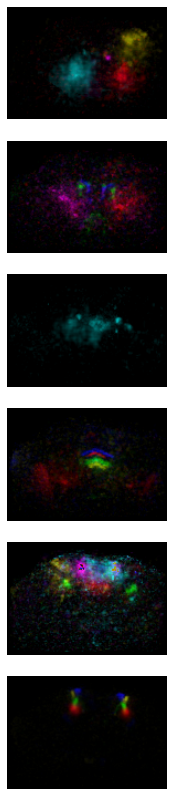

In [472]:
pylab.rcParams['figure.figsize'] = (7, 14)
import scipy
from scipy import ndimage

for i in range(L):
        plt.subplot(L,1,L-i)
        Rotated_Plot = ndimage.rotate(Regionmaps[:,:,i], -90)
        IM=plt.imshow(Rotated_Plot) 
        frame1 = plt.gca()
        frame1.axes.get_xaxis().set_visible(False)
        frame1.axes.get_yaxis().set_visible(False)
        

In [473]:
import scipy.io as sio
sio.savemat(foldername+'NewDT.mat',{'NewDT':NewDT})

In [474]:
names=set([Label_ICs[Neworder[i]] for i in range(len(Neworder))])  
for i in range(L):
    regionfilename=foldername+Regionname[i]+'.nii'
    D3=np.transpose(Datasort[:,:,:,i,:],(2,3,1,0))
    nim = NiftiImage(D3)
    nim.save(regionfilename)

In [352]:
%notebook -e 543KF.ipynb